In [1]:
import numpy as np
import cvxopt as co

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from niidbox.tcrfr_qp import TCRFR_QP
from niidbox.tcrfr_lbpa import TCRFR_lbpa

In [4]:
from niidbox.utils import profile, print_profiles

In [59]:
FRAC_LBLD_DATA = 0.1

In [60]:
data = np.load('niidbox-data/data_smiley.npz')
x = data['x']
y = data['y']
z = data['latent']
width = data['width']
height = data['height']
exms = x.shape[0]

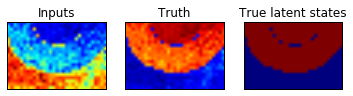

In [61]:
plt.subplot(1, 3, 1)
plt.imshow(x[:, 0].reshape((height, width), order='C'))
plt.title('Inputs')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
plt.imshow(y.reshape((height, width), order='C'))
plt.title('Truth')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
plt.imshow(z.reshape((height, width), order='C'))
plt.title('True latent states')
plt.xticks([])
plt.yticks([])

plt.show()

In [62]:
linds = np.random.permutation(exms)[:np.int(FRAC_LBLD_DATA*exms)]

In [63]:
A = co.spmatrix(0, [], [], (exms, exms), tc='d')
for k in range(1, 3):
    for i in range(height):
        for j in range(width):
            idx = i*width + j
            idx1 = (i+k)*width + j
            idx2 = i*width + j + k
            if k == 1 or (k>1 and idx in linds) or (k>1 and idx1 in linds) or (k>1 and idx2 in linds):
                if i < height-k:
                    A[idx, idx1] = 1
                    A[idx1, idx] = 1
                if j < width-k:
                    A[idx, idx2] = 1
                    A[idx2, idx] = 1

In [56]:
%%capture
qp   = TCRFR_QP(x.T.copy(), y[linds].copy(), linds, states=2, A=A, reg_theta=0.85, trans_sym=[1])
qp.fit(use_grads=False)

In [57]:
%%capture
lbpa = TCRFR_lbpa(x.T, y[linds], linds,  states=2, A=A, reg_theta=0.85, trans_sym=[1])
lbpa.verbosity_level = 2
lbpa.fit(use_grads=False, auto_adjust=True)

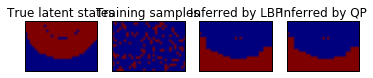

In [58]:
plt.subplot(1, 4, 1)
plt.imshow(z)
plt.title('True latent states')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 4, 2)
lbls = np.zeros(exms)
lbls[linds] = 1
plt.imshow(lbls.reshape((height, width), order='C'))
plt.title('Training samples')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 4, 3)
plt.imshow(lbpa.latent.reshape((height, width), order='C'))
plt.title('Inferred by LBP')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 4, 4)
plt.imshow(qp.latent.reshape((height, width), order='C'))
plt.title('Inferred by QP')
plt.xticks([])
plt.yticks([])

plt.show()